In [31]:
import pandas as pd
import benepar, spacy
import svgling
from nltk import Tree
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# benepar.download('benepar_en3')
# benepar.download('benepar_de2')
# !python -m spacy download en_core_web_md
# !python -m spacy download de_core_news_md
# !python -m spacy download de_dep_news_trf

In [137]:
nlp = spacy.load('en_core_web_md')
if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})

doc = nlp("The time for action is now. It's never too late to do something.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (NP (NP (DT The) (NN time)) (PP (IN for) (NP (NN action)))) (VP (VBZ is) (ADVP (RB now))) (. .))


In [138]:
nlp = spacy.load('de_core_news_md')
if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_de2"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_de2"})

doc = nlp("Sicherlich ist es nicht zu spät, etwas zu tun. Die Zeit für Aktionen ist jetzt.")
sent = list(doc.sents)[0]
print(sent._.parse_string)

(S (ADV Sicherlich) (VAFIN ist) (PPER es) (PTKNEG nicht) (AP (PTKA zu) (ADJD spät))) ($, ,) (VP (PIS etwas) (VZ (PTKZU zu) (VVINF tun))) ($. .)


In [139]:
spacy.displacy.render(doc, style="dep")

# Hands on our real data

In [3]:
# read in ../data/train_all_3k.csv
df = pd.read_csv('../data/train_updated.csv')
df.head()

,sent-id,topic,phrase,phrase_number,genre,timestamp,user,phrase_tokenized,num_statements,statement_spans
0,989,alchemie,Eine sehr bekannte Alchemisten war Maria die J...,2_long,Wissenschaft|Seiten_mit_defekten_Dateilinks,2022-10-03T06:15:06Z,48f66906899cc4a9477b6c9e32ff4424,0:=Eine 1:=sehr 2:=bekannte 3:=Alchemisten 4:=...,1,NaN
1,990,alchemie,Alchemisten wollen etwas ver-bessern.,3_long,Wissenschaft|Seiten_mit_defekten_Dateilinks,2022-10-03T06:15:06Z,48f66906899cc4a9477b6c9e32ff4424,0:=Alchemisten 1:=wollen 2:=etwas 3:=ver-bessern.,1,NaN
2,991,alchemie,"Zum Beispiel, \newline wollen sie kranke Mensc...",4_long,Wissenschaft|Seiten_mit_defekten_Dateilinks,2022-10-03T06:15:06Z,48f66906899cc4a9477b6c9e32ff4424,"0:=Zum 1:=Beispiel, 2:=\newline 3:=wollen 4:=s...",2,"[[3, 4], [5, 6, 7, 8]]"
3,992,alchemie,Alchemisten haben Athanoren benutzt.,5_long,Wissenschaft|Seiten_mit_defekten_Dateilinks,2022-10-03T06:15:06Z,48f66906899cc4a9477b6c9e32ff4424,0:=Alchemisten 1:=haben 2:=Athanoren 3:=benutzt.,1,NaN
4,993,alchemie,Sue haben Schwarz-pulver erfunden.,6_long,Wissenschaft|Seiten_mit_defekten_Dateilinks,2022-10-03T06:15:06Z,48f66906899cc4a9477b6c9e32ff4424,0:=Sue 1:=haben 2:=Schwarz-pulver 3:=erfunden.,1,NaN


In [141]:
# load up Benepar model to spaCY pipeline
nlp = spacy.load('de_dep_news_trf')

if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_de2"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_de2"})

In [142]:
def parse_sent_w_spacy(nlp, sent):

    doc = nlp(sent)
    sent = list(doc.sents)[0]
    toks = [token.text for token in doc]

    if "(S " in sent._.parse_string and "(V" in sent._.parse_string:
        is_sent = True
    elif len(toks) < 3:
        is_sent = True
    else:
        is_sent = False

    return sent._.parse_string, is_sent

In [143]:
sent = "Hier ist ein gutes Beispiel für einen einfachen Satz"

tree_as_string, is_sent = parse_sent_w_spacy(nlp, sent)
print(tree_as_string, is_sent)

(S (ADV Hier) (VAFIN ist) (NP (ART ein) (ADJA gutes) (NN Beispiel) (PP (APPR für) (ART einen) (ADJA einfachen) (NN Satz)))) True


In [144]:
for sent in df["phrase"][0:10]:
    tree_as_string, is_sent = parse_sent_w_spacy(nlp, sent)
    print(tree_as_string, is_sent)

(S (NP (ART Eine) (AP (ADV sehr) (ADJA bekannte)) (NN Alchemisten)) (VAFIN war) (PN (NE Maria) (NP (ART die) (NN Jüdin)))) ($. .) True
(S (NN Alchemisten) (VMFIN wollen) (VP (PIS etwas) (VVINF ver-bessern))) ($. .) True
(PP (APPRART Zum) (NN Beispiel)) ($, ,) (S (ADV \newline) (VMFIN wollen) (PPER sie) (VP (NP (ADJA kranke) (NN Menschen)) (ADJD gesund) (VVINF machen))) ($. .) True
(S (NN Alchemisten) (VAFIN haben) (VP (NN Athanoren) (VVPP benutzt))) ($. .) True
(S (NE Sue) (VAFIN haben) (VP (NN Schwarz-pulver) (VVPP erfunden))) ($. .) True
(S (KON Und) (PPER sie) (VAFIN haben) (VP (NN Porzellan) (VVPP erfunden))) ($. .) True
(S (NN Alchemie) (VAFIN ist) (NP (ART ein) (ADJA arabisches) (NN Wort))) ($. .) True
(S (NN Alchemie) (VAFIN ist) (NN Chemie)) ($. .) True
(S (NP (PPER Es)) (VAFIN werden) (CNP (NN Versuche) (KON und) (NN Experimente)) (VVPP gemacht)) ($. .) True
(S (KOUS Damit) (PIS man) (VVFIN versteht) (S (PWAV wie) (PIS etwas) (VVFIN funktioniert))) ($. .) True


In [145]:
results = []

for sent in tqdm(df["phrase"]):
    tree_as_string, is_sent = parse_sent_w_spacy(nlp, sent)
    results.append((sent, tree_as_string, is_sent))

100%|██████████| 2944/2944 [08:25<00:00,  5.83it/s]


In [3]:
# convert ls to DataFrame and save to ../data/bracket_is_sent_results.csv
df_results = pd.DataFrame(results, columns=["sentence", "tree", "is_sent"])
df_results.to_csv('../data/bracket_is_sent_results.csv', index=False)

## once the annotation results are ready

In [5]:
gold = []
for num_statements in df["num_statements"]:
    if num_statements == 0:
        gold.append(False)
    else:
        gold.append(True)

# read in train set
df = pd.read_csv('../data/train_updated.csv')
# read in brackets annotations
annotations = pd.read_csv('../data/bracket_is_sent_results.csv')
pred = annotations["is_sent"]

# calculate accuracy
accuracy = accuracy_score(gold, pred)
# create a DataFrame from the confusion matrix
cm = confusion_matrix(gold, pred)
cm_df = pd.DataFrame(cm)

print(accuracy)
print(cm_df)

0.9194972826086957
     0     1
0  303   146
1   91  2404


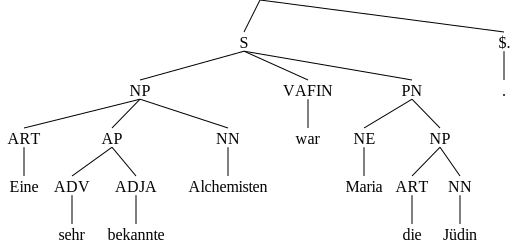

In [88]:
# transform the tree string into a NLTK tree object for bracket parsing
tree_strs  = ["(" + tree + ")" for tree in annotations["tree"]]

# visualize the first tree
Tree.fromstring(tree_strs[0]) 

In [117]:
def np_pp_size_count(tree_strs):
    # NP counts and sizes in each sentence
    np_count_sizes = []
    for tree in tree_strs:
        t = Tree.fromstring(tree)
        # find all NP subtrees
        np_subtrees = [subtree for subtree in t.subtrees() if subtree.label() == 'NP']

        num_np = len(np_subtrees)
        # if there is at least on NP, get the sizes of NP subtrees
        np_sizes = []
        if num_np:
            for subtree in np_subtrees:
                np_sizes.append(len(subtree.leaves()))
        else: 
            np_sizes.append(0)
        
        # append the count and sizes to the list
        np_count_sizes.append((num_np, np_sizes))

    # do the same for PP counts and sizes
    pp_count_sizes = []
    for tree in tree_strs:
        t = Tree.fromstring(tree)
        pp_subtrees = [subtree for subtree in t.subtrees() if subtree.label() == 'PP']

        num_pp = len(pp_subtrees)
        pp_sizes = []
        if num_pp:
            for subtree in pp_subtrees:
                pp_sizes.append(len(subtree.leaves()))
        else: 
            pp_sizes.append(0)
        
        pp_count_sizes.append((num_pp, pp_sizes))

    # create the DataFrame, first save the NP counts and sizes
    count_df = pd.DataFrame(np_count_sizes, columns=["num_np", "np_sizes"])

    num_pp, pp_sizes = zip(*pp_count_sizes)
    # add the new columns to the DataFrame
    count_df['num_pp'] = pd.Series(num_pp)
    count_df['pp_sizes'] = pd.Series(pp_sizes)

    return count_df

In [118]:
res = np_pp_size_count(tree_strs)

res

,num_np,np_sizes,num_pp,pp_sizes
0,2,"[4, 2]",0,[0]
1,0,[0],0,[0]
2,1,[2],1,[2]
3,0,[0],0,[0]
4,0,[0],0,[0]
...,...,...,...,...
2939,0,[0],0,[0]
2940,2,"[2, 2]",0,[0]
2941,0,[0],1,[4]
2942,0,[0],0,[0]


In [119]:
# save the DataFrame to ../data/np_pp_counts_sizes.csv
res.to_csv('../data/np_pp_counts_sizes.csv', index=False)

In [47]:
# Parse the string into a tree
tree = Tree.fromstring(tree_strs[2])

# Find the PP subtrees
pp_subtrees = [subtree for subtree in tree.subtrees() if subtree.label() == 'PP']

pp_count = len(pp_subtrees)

if pp_subtrees:
    sizes = []
    for subtree in pp_subtrees:
        sizes.append(len(subtree.leaves()))

# else:
#     continue

print(pp_count, sizes)

1 [2]


In [37]:
pp_subtrees

[Tree('NP', [Tree('ART', ['Eine']), Tree('AP', [Tree('ADV', ['sehr']), Tree('ADJA', ['bekannte'])]), Tree('NN', ['Alchemisten'])]),
 Tree('NP', [Tree('ART', ['die']), Tree('NN', ['Jüdin'])])]

In [34]:
for tree_str in tree_strs:
    # Parse the string into a tree
    tree = Tree.fromstring(tree_str)

    # Find the PP subtrees
    pp_subtrees = [subtree for subtree in tree.subtrees() if subtree.label() == 'PP']

    # Check if there are any PP subtrees
    if pp_subtrees:
        for pp_subtree in pp_subtrees:
            # Count the number of subtrees in the PP subtree
            num_subtrees = len(list(pp_subtree.subtrees()))

            print(f"A PP subtree has {num_subtrees} subtrees.")
    else:
        print("No PP subtree found.")

No PP subtree found.
No PP subtree found.
A PP subtree has 3 subtrees.
No PP subtree found.
No PP subtree found.
No PP subtree found.
No PP subtree found.
No PP subtree found.
No PP subtree found.
No PP subtree found.
A PP subtree has 3 subtrees.
A PP subtree has 3 subtrees.
No PP subtree found.
No PP subtree found.
No PP subtree found.
A PP subtree has 4 subtrees.
No PP subtree found.
A PP subtree has 4 subtrees.
A PP subtree has 5 subtrees.
A PP subtree has 4 subtrees.
A PP subtree has 2 subtrees.
No PP subtree found.
No PP subtree found.
No PP subtree found.
No PP subtree found.
A PP subtree has 3 subtrees.
A PP subtree has 4 subtrees.
A PP subtree has 3 subtrees.
A PP subtree has 3 subtrees.
No PP subtree found.
A PP subtree has 3 subtrees.
A PP subtree has 3 subtrees.
A PP subtree has 4 subtrees.
No PP subtree found.
A PP subtree has 5 subtrees.
A PP subtree has 4 subtrees.
No PP subtree found.
No PP subtree found.
A PP subtree has 4 subtrees.
A PP subtree has 3 subtrees.
No PP su

In [33]:
for tree_str in tree_strs:
    # Parse the string into a tree
    tree = Tree.fromstring(tree_str)

    # Find the PP subtrees
    pp_subtrees = [subtree for subtree in tree.subtrees() if subtree.label() == 'NP']

    # Check if there are any PP subtrees
    if pp_subtrees:
        # Get the first PP subtree
        pp_subtree = pp_subtrees[0]

        # # Print the labels of the subtrees in the PP subtree
        # for subtree in pp_subtree.subtrees():
        #     print(subtree.label())

        # Count the number of subtrees in the PP subtree
        num_subtrees = len(list(pp_subtree.subtrees()))

        print(f"The PP subtree has {num_subtrees} subtrees.")
    else:
        # print("No PP subtree found.")
        continue

The PP subtree has 6 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 4 subtrees.
The PP subtree has 2 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 4 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 6 subtrees.
The PP subtree has 8 subtrees.
The PP subtree has 7 subtrees.
The PP subtree has 7 subtrees.
The PP subtree has 11 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 4 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 6 subtrees.
The PP subtree has 7 subtrees.
The PP subtree has 7 subtrees.
The PP subtree has 8 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 6 subtrees.
The PP subtree has 5 subtrees.
The PP subtree has 11 subtrees.
The PP subtree has 3 subtrees.
The PP subtree has 3 subtrees.
The PP

In [5]:
parser = benepar.Parser("benepar_de2")

In [3]:
def parse_sentence(df, sent_idx):
    # extract pre-tokenizes sentence
    sent_toks = df['phrase_tokenized'][sent_idx].split()
    sent_toks = [s.split(':=')[1] for s in sent_toks]
            
    # parse the sentence
    result = parser.parse(sent_toks)

    # some extra gold information
    tokens = df['phrase_tokenized'][sent_idx]
    statement_spans = df['statement_spans '][sent_idx]

    return result, tokens, statement_spans


In [9]:
result0, tokens0, statement_spans0 = parse_sentence(df, 0)

print(result0)
print(tokens0)
print(statement_spans0)

(TOP
  (NP (ART Eine) (AP (ADV sehr) (ADJA bekannte)) (NN Alchemisten))
  (VAFIN war)
  (NE Maria)
  (ART die)
  ($. Jüdin.))
0:=Eine 1:=sehr 2:=bekannte 3:=Alchemisten 4:=war 5:=Maria 6:=die 7:=Jüdin.
nan


In [6]:
result2, tokens2, statement_spans2 = parse_sentence(df, 2)

print(result2)
print(tokens2)
print(statement_spans2)

(TOP
  (APPRART Zum)
  ($, Beispiel,)
  (ADV \newline)
  (VMFIN wollen)
  (PPER sie)
  (NP (ADJA kranke) (NN Menschen))
  (ADJD gesund)
  ($. machen.))
0:=Zum 1:=Beispiel, 2:=\newline 3:=wollen 4:=sie 5:=kranke 6:=Menschen 7:=gesund 8:=machen.
[[3, 4], [5, 6, 7, 8]]


In [7]:
sent_toks = [
    "Hier",
    "ist",
    "ein",
    "gutes",
    "Beispiel",
    "für",
    "einen",
    "einfachen",
    "Satz"
 ]
        
# parse the sentence
result = parser.parse(sent_toks)
print(result)

(TOP
  (S
    (ADV Hier)
    (VAFIN ist)
    (NP
      (ART ein)
      (ADJA gutes)
      (NN Beispiel)
      (PP (APPR für) (ART einen) (ADJA einfachen) (NN Satz)))))


In [12]:
[s.split(':=')[1] for s in df['phrase_tokenized'][2].split()]

['Zum',
 'Beispiel,',
 '\\newline',
 'wollen',
 'sie',
 'kranke',
 'Menschen',
 'gesund',
 'machen.']

In [14]:
import nltk
from nltk import Tree

def extract_nps(tagged_sentence):
    tree = Tree.fromstring(tagged_sentence)
    nps = []
    
    for subtree in tree.subtrees():
        if subtree.label() == 'NN':
            np_words = subtree.leaves()
            np_string = ' '.join(np_words)
            nps.append(np_string)
    
    return nps

# Example usage
tagged_sentence = "(TOP (S (ADV Meistens) (VAFIN werden) (NN Alkopos) (PP (APPR in) (ADJA bunten) (NN Flaschen))) ($. verkauft.))"
nps = extract_nps(tagged_sentence)
for np in nps:
    print(np)


Alkopos
Flaschen


In [15]:
import nltk
from nltk import Tree

def extract_nouns_with_sizes(tagged_sentence):
    tree = Tree.fromstring(tagged_sentence)
    nouns_with_sizes = []
    
    for subtree in tree.subtrees():
        if subtree.label() in {'NN', 'NNS', 'NNP', 'NNPS'}:
            noun_words = subtree.leaves()
            noun_size = len(noun_words)
            noun_string = ' '.join(noun_words)
            nouns_with_sizes.append((noun_string, noun_size))
    
    return nouns_with_sizes

# Example usage
tagged_sentence = "(TOP (S (ADV Meistens) (VAFIN werden) (NN (ADJ bunte) Flasche) (PP (APPR in) (ADJA bunten) (NN Flaschen))) ($. verkauft.))"
nouns_with_sizes = extract_nouns_with_sizes(tagged_sentence)
for noun, size in nouns_with_sizes:
    print(f"NN: {noun}, Size: {size}")

NN: bunte Flasche, Size: 2
NN: Flaschen, Size: 1


In [16]:
import nltk
from nltk import Tree

def extract_nouns_with_sizes(tagged_sentence):
    tree = Tree.fromstring(tagged_sentence)
    nouns_with_sizes = []
    
    for subtree in tree.subtrees():
        if subtree.label() in {'S', 'TOP'}:
            noun_words = subtree.leaves()
            noun_size = len(noun_words)
            noun_string = ' '.join(noun_words)
            nouns_with_sizes.append((noun_string, noun_size))
    
    return nouns_with_sizes

# Example usage
tagged_sentence = "(TOP (S (ADV Meistens) (VAFIN werden) (NN (ADJ bunte) Flasche) (PP (APPR in) (ADJA bunten) (NN Flaschen))) ($. verkauft.))"
nouns_with_sizes = extract_nouns_with_sizes(tagged_sentence)
for noun, size in nouns_with_sizes:
    print(f"NN: {noun}, Size: {size}")

NN: Meistens werden bunte Flasche in bunten Flaschen verkauft., Size: 8
NN: Meistens werden bunte Flasche in bunten Flaschen, Size: 7
